In [1]:
%matplotlib notebook
#import matplotlib.pyplot as plt
# Note! ITK interacts weirdly here.  from lazy_imports import itk does not work.
# Additionally, import itk must occur before lazy_imports for itkwidgets.view (ie itkview) to work.
import itk
import vtk
#from lazy_imports import itk
from lazy_imports import np
from lazy_imports import plt
from lazy_imports import sitk
from lazy_imports import loadmat, savemat
from lazy_imports import sio
from lazy_imports import itkwidgets
from lazy_imports import itkview
from lazy_imports import interactive
from lazy_imports import ipywidgets
from lazy_imports import pv
from lazy_imports import torch
plt.rcParams["figure.figsize"] = (6, 6) # (w, h)

In [2]:
from disp.vis import show_2d, show_2d_tensors
from disp.vis import vis_tensors, vis_path
from disp.vis import view_3d_tensors, tensors_to_mesh, view_3d_paths, path_to_tube

In [79]:
from data.io import readRaw, ReadScalars, ReadTensors, WriteTensorNPArray, WriteScalarNPArray, readPath3D
from data.convert import GetNPArrayFromSITK, GetSITKImageFromNP
import algo.metricModSolver as mms
import algo.geodesic as geo
import algo.euler as euler
import util.tensors as tensors
import util.diffeo as diffeo
import util.diff as diff
from util import maskops as mo
from util.riemann import riem_vec_norm
import pickle
import math
import ipywebrtc
from IPython.display import display
import time

In [4]:
# from colorbrewer2, sequential 9 values pasted together YlGnBu (reverse order) then YlOrRd
# EXCEPT THESE ARE NOT PRINT FRIENDLY OR PHOTOCOPY SAFE!!!
# But skip the yellows in the middle -- too light
geo_colors = ['tab:red', 'tab:pink', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:cyan']
eul_colors = ['k', 'tab:gray', 'tab:brown', 'm', 'y', 'tab:olive', 'maroon']
#interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4', '#edf8b1', '#ffffd9',
#                 '#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']
interp_colors = ['#081d58', '#253494', '#225ea8', '#1d91c0', '#41b6c4', '#7fcdbb', '#c7e9b4',
                 '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026']

blue=interp_colors[3]
ltblue=interp_colors[6]
yellow=interp_colors[7]
orange=interp_colors[9]
red=interp_colors[12]

# 3 classes are safest, but fewer options.
# Stitch together some options from sequential 3 values YlGnBu (reverse order), YlOrBr and 
#interp_colors = ['#2c7fb8', '#7fcdbb', '#edf8b1', '#fff7bc', '#fec44f', '#d95f0e']

# Compromise, use 5 class YlGnBu (reverse order) and YlOrBr again leaving out yellow
interp_colors = ['#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']
# leave out #ffffcc and #ffffd4

blue=interp_colors[1]
ltblue=interp_colors[2]
yellow=interp_colors[4]
orange=interp_colors[5]
red=interp_colors[7]

# Same as above but with a dark gray added in the front
interp_colors = ['#777777','#253494', '#2c7fb8', '#41b6c4', '#a1dab4', '#fed98e', '#fe9929', '#d95f0e', '#993404']

blue=interp_colors[2]
ltblue=interp_colors[3]
yellow=interp_colors[5]
orange=interp_colors[6]
red=interp_colors[8]

# matches defaults
XSMALL_SIZE = 12
SMALL_SIZE = 15
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
# bigger for papers
XSMALL_SIZE = 12
SMALL_SIZE = 17
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

#plt.rcParams["figure.figsize"] = (4, 4) # (w, h)
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Look at 3D eigenvector ambiguities

In [23]:
outdir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python/'

indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestData/3D/'

num_iters = 4500
geo_delta_t = 0.1
euler_delta_t = 0.1
geo_iters = 3000 # 22000 for Kris annulus(delta_t=0.005), 32000 for cubic (delta_t=0.005)
euler_iters = 3250

res = {}

for cc in range(1,8):
  run_case = f"cubic{cc}"
  res[run_case] = {}
  tens_file = f'metpy_3D_{run_case}_tens.nhdr'
  mask_file = f'metpy_3D_{run_case}_mask.nhdr'
  res[run_case]['tens_file'] = tens_file
  res[run_case]['mask_file'] = mask_file

  in_tens = ReadTensors(indir+'/'+tens_file)
  in_mask = ReadScalars(indir+'/'+mask_file)
  out_prefix = outdir + 'cubic200iter/' + run_case
  scaled_tens = ReadTensors(out_prefix+'_scaled_tensors.nhdr')
  filt_mask = ReadScalars(out_prefix+'_filt_mask.nhdr')

  scaled_tens_4_path = np.transpose(scaled_tens,(3,0,1,2))
  tens_4_path = np.transpose(in_tens,(3,0,1,2))

  res[run_case]['scaled_tens'] = scaled_tens_4_path
  res[run_case]['orig_tens'] = tens_4_path
  res[run_case]['tens'] = in_tens
  res[run_case]['mask'] = filt_mask


run_case = f"annulus"
res[run_case] = {}
tens_file = f'metpy_{run_case}_3D_tens.nhdr'
mask_file = f'metpy_{run_case}_3D_mask.nhdr'
res[run_case]['tens_file'] = tens_file
res[run_case]['mask_file'] = mask_file

in_tens = ReadTensors(indir+'/'+tens_file)
in_mask = ReadScalars(indir+'/'+mask_file)
out_prefix = outdir + run_case
scaled_tens = ReadTensors(out_prefix+'_scaled_tensors.nhdr')
filt_mask = ReadScalars(out_prefix+'_filt_mask.nhdr')

scaled_tens_4_path = np.transpose(scaled_tens,(3,0,1,2))
tens_4_path = np.transpose(in_tens,(3,0,1,2))

res[run_case]['scaled_tens'] = scaled_tens_4_path
res[run_case]['orig_tens'] = tens_4_path
res[run_case]['tens'] = in_tens
res[run_case]['mask'] = filt_mask
    


In [6]:
cases = []
cases.append('105923')
cases.append('102715')
cases.append('108222')
t1s = []
in_tensors = []
out_tensors = []
outdirs = []
out_masks = []
alphas = []
fas = []
for run_case in cases:
  subj = run_case[:6]
  #outroot='/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/working_3d_python/'
  outroot = '/usr/sci/projects/HCP/Kris/NSFCRCNS/TestResults/UKF_experiments/BallResults/'
  #indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_data/' + subj + '/'
  indir = '/usr/sci/projects/HCP/Kris/NSFCRCNS/prepped_UKF_data_with_grad_dev/' + subj + '/'
  outdir = f'{outroot}{run_case}_'
  outdirs.append(outdir)

  tens_file = 'dti_all_tensor.nhdr'
  in_tens = ReadTensors(indir + tens_file)
  in_tensors.append(in_tens)
  tens_file = 'scaled_tensors.nhdr'
  out_tens = ReadTensors(outdir + tens_file)
  out_tensors.append(out_tens)
  #t1_file = 't1_stripped_irescaled.nhdr'
  #t1 = ReadScalars(indir + t1_file)
  t1_file = 'T1.nhdr'
  t1 = ReadScalars(outdir + t1_file)
  t1s.append(t1)
  #t1_flip = ReadScalars(indir + 't1_rescaled_flipped.nhdr')[:,::-1,:]
  mask_file = 'filt_mask.nhdr'
  mask = ReadScalars(outdir + mask_file)
  out_masks.append(mask)
  alpha_file = 'alpha.nhdr'
  alpha = ReadScalars(outdir + alpha_file)
  alphas.append(alpha)
  fa_file = 'dti_all_FA.nhdr'
  fa = ReadScalars(indir + fa_file)
  fas.append(fa)
    


In [89]:
%%time
show_brain=False
if show_brain:
  casenum=0
  tens = tensors.tens_6_to_tens_3x3(in_tensors[casenum])
  mask = out_masks[casenum]
  bdry_type, bdry_idx, bdry_map = mo.determine_boundary_3d(mask, False)
else:
  run_case='cubic7'
  run_case='annulus'
  tens = tensors.tens_6_to_tens_3x3(res[run_case]['tens'])
  mask = res[run_case]['mask']
  bdry_type, bdry_idx, bdry_map = mo.determine_boundary_3d(mask, False)
    
xsz=mask.shape[0]
ysz=mask.shape[1]
zsz=mask.shape[2]
    
scale_factor = 1.0
max_tens = np.max(tens)
while scale_factor * max_tens < 1:
  scale_factor = scale_factor * 10
print("Scaling tensors by factor of", scale_factor)
tens *= scale_factor
iso_tens = np.zeros((3,3),dtype=np.double)
iso_tens[0,0] = 1.0 / scale_factor
iso_tens[1,1] = 1.0 / scale_factor
iso_tens[2,2] = 1.0 / scale_factor 

tens[mask == 0] = iso_tens
g = np.linalg.inv(tens)
g[np.isnan(g)] = 0

eigenvecs = tensors.eigv_3d(tens)
TDir = riem_vec_norm(eigenvecs[:,:,:,:,2], g, np)
TDir[np.isnan(TDir)] = 0
TDir[np.isinf(TDir)] = 0

TDirx, TDiry, TDirz = tensors.eigv_sign_deambig(TDir)
gradTx_delx, gradTx_dely, gradTx_delz, gradTy_delx, gradTy_dely, gradTy_delz, gradTz_delx, gradTz_dely, gradTz_delz = mms.compute_T_derivs_new(TDirx, TDiry, TDirz, bdry_idx, bdry_map, np)
gradTDirx_delx, gradTDirx_dely, gradTDirx_delz, gradTDiry_delx, gradTDiry_dely, gradTDiry_delz, gradTDirz_delx, gradTDirz_dely, gradTDirz_delz = mms.compute_T_derivs_new(TDir, TDir, TDir, bdry_idx, bdry_map, np)

Found 0 voxels where unable to take 1st derivative.
Found 0 reduced accuracy 2nd derivative voxels.
Scaling tensors by factor of 1.0
CPU times: user 6.71 s, sys: 2.13 s, total: 8.85 s
Wall time: 5.77 s


In [90]:
first_nabla_TT = np.zeros((xsz,ysz,zsz,3),dtype=np.double)
first_nabla_TT[:,:,:,0] = np.multiply(TDirx[:,:,:,0], gradTx_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], gradTx_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], gradTx_delz[:,:,:])
first_nabla_TT[:,:,:,1] = np.multiply(TDirx[:,:,:,0], gradTy_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], gradTy_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], gradTy_delz[:,:,:])
first_nabla_TT[:,:,:,2] = np.multiply(TDirx[:,:,:,0], gradTz_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], gradTz_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], gradTz_delz[:,:,:])
first_nabla_TTDir = np.zeros((xsz,ysz,zsz,3),dtype=np.double)
first_nabla_TTDir[:,:,:,0] = np.multiply(TDir[:,:,:,0], gradTDirx_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], gradTDirx_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], gradTDirx_delz[:,:,:])
first_nabla_TTDir[:,:,:,1] = np.multiply(TDir[:,:,:,0], gradTDiry_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], gradTDiry_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], gradTDiry_delz[:,:,:])
first_nabla_TTDir[:,:,:,2] = np.multiply(TDir[:,:,:,0], gradTDirz_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], gradTDirz_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], gradTDirz_delz[:,:,:])

In [25]:
np.any(np.isnan(TDir))

False

In [91]:
diffTx_delx = np.zeros((xsz,ysz,zsz))
diffTx_dely = np.zeros((xsz,ysz,zsz))
diffTx_delz = np.zeros((xsz,ysz,zsz))
diffTy_delx = np.zeros((xsz,ysz,zsz))
diffTy_dely = np.zeros((xsz,ysz,zsz))
diffTy_delz = np.zeros((xsz,ysz,zsz))
diffTz_delx = np.zeros((xsz,ysz,zsz))
diffTz_dely = np.zeros((xsz,ysz,zsz))
diffTz_delz = np.zeros((xsz,ysz,zsz))
diffTDirx_delx = np.zeros((xsz,ysz,zsz))
diffTDirx_dely = np.zeros((xsz,ysz,zsz))
diffTDirx_delz = np.zeros((xsz,ysz,zsz))
diffTDiry_delx = np.zeros((xsz,ysz,zsz))
diffTDiry_dely = np.zeros((xsz,ysz,zsz))
diffTDiry_delz = np.zeros((xsz,ysz,zsz))
diffTDirz_delx = np.zeros((xsz,ysz,zsz))
diffTDirz_dely = np.zeros((xsz,ysz,zsz))
diffTDirz_delz = np.zeros((xsz,ysz,zsz))
for btype, bnum in bdry_map.items():
    if bnum == 0:
      # skip, since outside
      continue

    b_idx = bdry_idx[bnum]
    
    xdiff,ydiff,zdiff = diff.select_diffs_3d(btype,zero_shifts=False)

    if btype == "outside":
      # outside mask, skip
      continue
    else:
      diffTx_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDirx[:,:,:,0], b_idx)
      diffTx_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDirx[:,:,:,0], b_idx)
      diffTx_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDirx[:,:,:,0], b_idx)
      diffTy_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDiry[:,:,:,1], b_idx)
      diffTy_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDiry[:,:,:,1], b_idx)
      diffTy_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDiry[:,:,:,1], b_idx)
      diffTz_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDirz[:,:,:,2], b_idx)
      diffTz_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDirz[:,:,:,2], b_idx)
      diffTz_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDirz[:,:,:,2], b_idx)
      diffTDirx_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDir[:,:,:,0], b_idx)
      diffTDirx_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDir[:,:,:,0], b_idx)
      diffTDirx_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDir[:,:,:,0], b_idx)
      diffTDiry_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDir[:,:,:,1], b_idx)
      diffTDiry_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDir[:,:,:,1], b_idx)
      diffTDiry_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDir[:,:,:,1], b_idx)
      diffTDirz_delx[b_idx[0],b_idx[1],b_idx[2]] = xdiff(TDir[:,:,:,2], b_idx)
      diffTDirz_dely[b_idx[0],b_idx[1],b_idx[2]] = ydiff(TDir[:,:,:,2], b_idx)
      diffTDirz_delz[b_idx[0],b_idx[1],b_idx[2]] = zdiff(TDir[:,:,:,2], b_idx)
      


In [92]:
first_nabla_TdiffT = np.zeros((xsz,ysz,zsz,3),dtype=np.double)
first_nabla_TdiffT[:,:,:,0] = np.multiply(TDirx[:,:,:,0], diffTx_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], diffTx_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], diffTx_delz[:,:,:])
first_nabla_TdiffT[:,:,:,1] = np.multiply(TDirx[:,:,:,0], diffTy_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], diffTy_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], diffTy_delz[:,:,:])
first_nabla_TdiffT[:,:,:,2] = np.multiply(TDirx[:,:,:,0], diffTz_delx[:,:,:]) + np.multiply(TDiry[:,:,:,1], diffTz_dely[:,:,:]) + np.multiply(TDirz[:,:,:,2], diffTz_delz[:,:,:])
first_nabla_TdiffTDir = np.zeros((xsz,ysz,zsz,3),dtype=np.double)
first_nabla_TdiffTDir[:,:,:,0] = np.multiply(TDir[:,:,:,0], diffTDirx_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], diffTDirx_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], diffTDirx_delz[:,:,:])
first_nabla_TdiffTDir[:,:,:,1] = np.multiply(TDir[:,:,:,0], diffTDiry_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], diffTDiry_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], diffTDiry_delz[:,:,:])
first_nabla_TdiffTDir[:,:,:,2] = np.multiply(TDir[:,:,:,0], diffTDirz_delx[:,:,:]) + np.multiply(TDir[:,:,:,1], diffTDirz_dely[:,:,:]) + np.multiply(TDir[:,:,:,2], diffTDirz_delz[:,:,:])


In [93]:
#itkview(first_nabla_TTDir[:,:,:,0])
itkview(TDir[:,:,:,0])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [59]:
#itkview(first_nabla_TT[:,:,:,2])
itkview(TDirx[:,:,:,0])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [62]:
itkview(gradTDirx_delx)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [67]:
itkview(gradTx_delx)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [94]:
itkview(first_nabla_TdiffT[:,:,:,1])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [95]:
itkview(first_nabla_TdiffTDir[:,:,:,1])

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [96]:
ndiff=first_nabla_TTDir-first_nabla_TT
ndiff2=first_nabla_TdiffTDir-first_nabla_TdiffT
print(np.min(ndiff),np.max(ndiff))
print(np.min(ndiff2),np.max(ndiff2))

-1.0877919644084146e-15 0.5477225952122722
-5.998761137188238 5.998761137188238


In [34]:
itkview(ndiff[:,:,:,1])#, label_image=mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

<IPython.core.display.Javascript object>


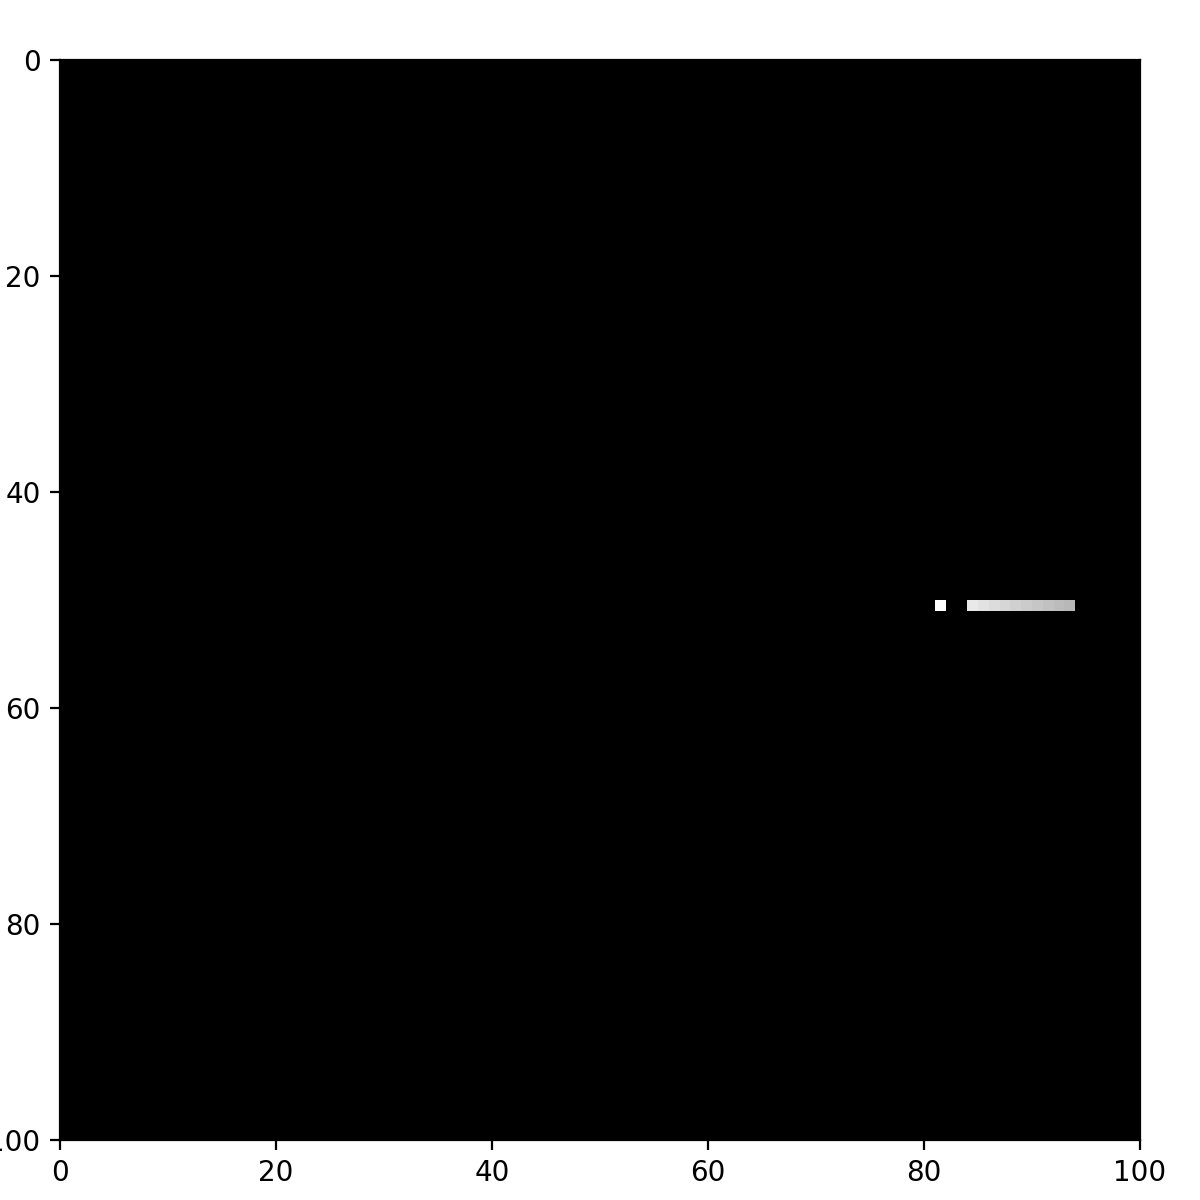

In [60]:
show_2d(ndiff[:,:,20,1])

In [100]:
itkview(ndiff2[:,:,:,0])#, label_image=mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…